In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F

## Defining some helper functions

### Group Normalization

In [18]:
class GroupNorm(nn.Module):
    def __init__(self, channels):
        super(GroupNorm, self).__init__()
        self.gn = nn.GroupNorm(num_groups=32, num_channels=channels, eps=1e-6, affine=True)

    def forward(self, x):
        return self.gn(x)


### Swish Activation

In [19]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

### Residual Block

In [20]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.block = nn.Sequential(
            GroupNorm(in_channels),
            Swish(),
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            GroupNorm(out_channels),
            Swish(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1)
        )

        if in_channels != out_channels:
            self.channel_up = nn.Conv2d(in_channels, out_channels, 1, 1, 0)

    def forward(self, x):
        if self.in_channels != self.out_channels:
            return self.channel_up(x) + self.block(x)
        else:
            return x + self.block(x)


### Upsampling Block

In [21]:
class UpSampleBlock(nn.Module):
    def __init__(self, channels):
        super(UpSampleBlock, self).__init__()
        self.conv = nn.Conv2d(channels, channels, 3, 1, 1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2.0)
        return self.conv(x)


### Downsampling Block

In [22]:
class DownSampleBlock(nn.Module):
    def __init__(self, channels):
        super(DownSampleBlock, self).__init__()
        self.conv = nn.Conv2d(channels, channels, 3, 2, 0)

    def forward(self, x):
        pad = (0, 1, 0, 1)
        x = F.pad(x, pad, mode="constant", value=0)
        return self.conv(x)


### Transformer Block

In [23]:
class NonLocalBlock(nn.Module):
    def __init__(self, channels):
        super(NonLocalBlock, self).__init__()
        self.in_channels = channels

        self.gn = GroupNorm(channels)
        self.q = nn.Conv2d(channels, channels, 1, 1, 0)
        self.k = nn.Conv2d(channels, channels, 1, 1, 0)
        self.v = nn.Conv2d(channels, channels, 1, 1, 0)
        self.proj_out = nn.Conv2d(channels, channels, 1, 1, 0)

    def forward(self, x):
        h_ = self.gn(x)
        q = self.q(h_)
        k = self.k(h_)
        v = self.v(h_)

        b, c, h, w = q.shape

        q = q.reshape(b, c, h*w)
        q = q.permute(0, 2, 1)
        k = k.reshape(b, c, h*w)
        v = v.reshape(b, c, h*w)

        attn = torch.bmm(q, k)
        attn = attn * (int(c)**(-0.5))
        attn = F.softmax(attn, dim=2)
        attn = attn.permute(0, 2, 1)

        A = torch.bmm(v, attn)
        A = A.reshape(b, c, h, w)

        return x + A

## Initialiing the Encoder class

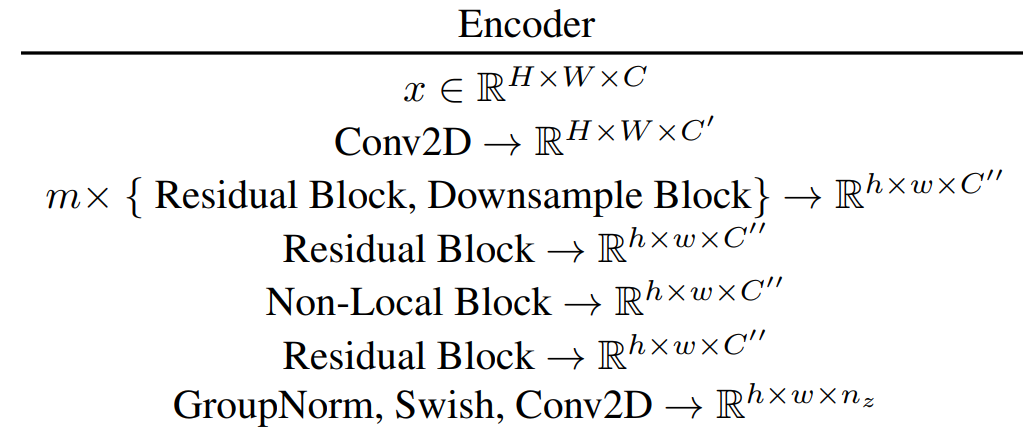

In [24]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, args):
        super(Encoder, self).__init__()
        channels = [128, 128, 128, 256, 256, 512]
        attn_resolutions = [16]
        num_res_blocks = 2
        resolution = 256
        layers = [nn.Conv2d(args.image_channels, channels[0], 3, 1, 1)]
        for i in range(len(channels)-1):
            in_channels = channels[i]
            out_channels = channels[i + 1]
            for j in range(num_res_blocks):
                layers.append(ResidualBlock(in_channels, out_channels))
                in_channels = out_channels
                if resolution in attn_resolutions:
                    layers.append(NonLocalBlock(in_channels))
            if i != len(channels)-2:
                layers.append(DownSampleBlock(channels[i+1]))
                resolution //= 2
        layers.append(ResidualBlock(channels[-1], channels[-1]))
        layers.append(NonLocalBlock(channels[-1]))
        layers.append(ResidualBlock(channels[-1], channels[-1]))
        layers.append(GroupNorm(channels[-1]))
        layers.append(Swish())
        layers.append(nn.Conv2d(channels[-1], args.latent_dim, 3, 1, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

## Initializing the Deocder Class

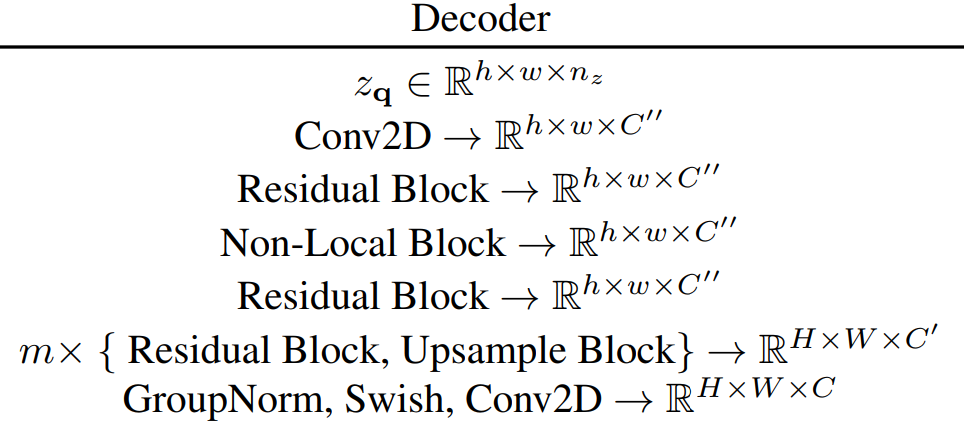

In [25]:
import torch.nn as nn

class Decoder(nn.Module):
    def __init__(self, args):
        super(Decoder, self).__init__()
        channels = [512, 256, 256, 128, 128]
        attn_resolutions = [16]
        num_res_blocks = 3
        resolution = 16

        in_channels = channels[0]
        layers = [nn.Conv2d(args.latent_dim, in_channels, 3, 1, 1),
                  ResidualBlock(in_channels, in_channels),
                  NonLocalBlock(in_channels),
                  ResidualBlock(in_channels, in_channels)]

        for i in range(len(channels)):
            out_channels = channels[i]
            for j in range(num_res_blocks):
                layers.append(ResidualBlock(in_channels, out_channels))
                in_channels = out_channels
                if resolution in attn_resolutions:
                    layers.append(NonLocalBlock(in_channels))
            if i != 0:
                layers.append(UpSampleBlock(in_channels))
                resolution *= 2

        layers.append(GroupNorm(in_channels))
        layers.append(Swish())
        layers.append(nn.Conv2d(in_channels, args.image_channels, 3, 1, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

## Creating a CodeBook

In [26]:
class Codebook(nn.Module):
    def __init__(self, args):
        super(Codebook, self).__init__()
        self.num_codebook_vectors = args.num_codebook_vectors
        self.latent_dim = args.latent_dim
        self.beta = args.beta

        self.embedding = nn.Embedding(self.num_codebook_vectors, self.latent_dim)
        self.embedding.weight.data.uniform_(-1.0 / self.num_codebook_vectors, 1.0 / self.num_codebook_vectors)

    def forward(self, z):
        z = z.permute(0, 2, 3, 1).contiguous()
        z_flattened = z.view(-1, self.latent_dim)

        d = torch.sum(z_flattened**2, dim=1, keepdim=True) + \
            torch.sum(self.embedding.weight**2, dim=1) - \
            2*(torch.matmul(z_flattened, self.embedding.weight.t()))

        min_encoding_indices = torch.argmin(d, dim=1)
        z_q = self.embedding(min_encoding_indices).view(z.shape)

        loss = torch.mean((z_q.detach() - z)**2) + self.beta * torch.mean((z_q - z.detach())**2)

        z_q = z + (z_q - z).detach()

        z_q = z_q.permute(0, 3, 1, 2)

        return z_q, min_encoding_indices, loss

## VQGAN

Integrating the above defined modules

In [27]:
class VQGAN(nn.Module):
    def __init__(self, args):
        super(VQGAN, self).__init__()
        self.encoder = Encoder(args).to(device=args.device)
        self.decoder = Decoder(args).to(device=args.device)
        self.codebook = Codebook(args).to(device=args.device)
        self.quant_conv = nn.Conv2d(args.latent_dim, args.latent_dim, 1).to(device=args.device)
        self.post_quant_conv = nn.Conv2d(args.latent_dim, args.latent_dim, 1).to(device=args.device)

    def forward(self, imgs):
        encoded_images = self.encoder(imgs)
        quant_conv_encoded_images = self.quant_conv(encoded_images)
        codebook_mapping, codebook_indices, q_loss = self.codebook(quant_conv_encoded_images)
        post_quant_conv_mapping = self.post_quant_conv(codebook_mapping)
        decoded_images = self.decoder(post_quant_conv_mapping)

        return decoded_images, codebook_indices, q_loss

    def encode(self, imgs):
        encoded_images = self.encoder(imgs)
        quant_conv_encoded_images = self.quant_conv(encoded_images)
        codebook_mapping, codebook_indices, q_loss = self.codebook(quant_conv_encoded_images)
        return codebook_mapping, codebook_indices, q_loss

    def decode(self, z):
        post_quant_conv_mapping = self.post_quant_conv(z)
        decoded_images = self.decoder(post_quant_conv_mapping)
        return decoded_images

    def calculate_lambda(self, perceptual_loss, gan_loss):
        last_layer = self.decoder.model[-1]
        last_layer_weight = last_layer.weight
        perceptual_loss_grads = torch.autograd.grad(perceptual_loss, last_layer_weight, retain_graph=True)[0]
        gan_loss_grads = torch.autograd.grad(gan_loss, last_layer_weight, retain_graph=True)[0]

        λ = torch.norm(perceptual_loss_grads) / (torch.norm(gan_loss_grads) + 1e-4)
        λ = torch.clamp(λ, 0, 1e4).detach()
        return 0.8 * λ

    @staticmethod
    def adopt_weight(disc_factor, i, threshold, value=0.):
        if i < threshold:
            disc_factor = value
        return disc_factor

    def load_checkpoint(self, path):
        self.load_state_dict(torch.load(path))

## Discriminator

Taken from 
 
PatchGAN Discriminator (https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py#L538)



In [28]:
import torch.nn as nn


class Discriminator(nn.Module):
    def __init__(self, args, num_filters_last=64, n_layers=3):
        super(Discriminator, self).__init__()

        layers = [nn.Conv2d(args.image_channels, num_filters_last, 4, 2, 1), nn.LeakyReLU(0.2)]
        num_filters_mult = 1

        for i in range(1, n_layers + 1):
            num_filters_mult_last = num_filters_mult
            num_filters_mult = min(2 ** i, 8)
            layers += [
                nn.Conv2d(num_filters_last * num_filters_mult_last, num_filters_last * num_filters_mult, 4,
                          2 if i < n_layers else 1, 1, bias=False),
                nn.BatchNorm2d(num_filters_last * num_filters_mult),
                nn.LeakyReLU(0.2, True)
            ]

        layers.append(nn.Conv2d(num_filters_last * num_filters_mult, 1, 4, 1, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


## LPIPS

A loss function also taken from above mentioned source

In [29]:
import os
import torch
import torch.nn as nn
from torchvision.models import vgg16
from collections import namedtuple
import requests
from tqdm import tqdm


URL_MAP = {
    "vgg_lpips": "https://heibox.uni-heidelberg.de/f/607503859c864bc1b30b/?dl=1"
}

CKPT_MAP = {
    "vgg_lpips": "vgg.pth"
}


def download(url, local_path, chunk_size=1024):
    os.makedirs(os.path.split(local_path)[0], exist_ok=True)
    with requests.get(url, stream=True) as r:
        total_size = int(r.headers.get("content-length", 0))
        with tqdm(total=total_size, unit="B", unit_scale=True) as pbar:
            with open(local_path, "wb") as f:
                for data in r.iter_content(chunk_size=chunk_size):
                    if data:
                        f.write(data)
                        pbar.update(chunk_size)


def get_ckpt_path(name, root):
    assert name in URL_MAP
    path = os.path.join(root, CKPT_MAP[name])
    if not os.path.exists(path):
        print(f"Downloading {name} model from {URL_MAP[name]} to {path}")
        download(URL_MAP[name], path)
    return path


class LPIPS(nn.Module):
    def __init__(self):
        super(LPIPS, self).__init__()
        self.scaling_layer = ScalingLayer()
        self.channels = [64, 128, 256, 512, 512]
        self.vgg = VGG16()
        self.lins = nn.ModuleList([
            NetLinLayer(self.channels[0]),
            NetLinLayer(self.channels[1]),
            NetLinLayer(self.channels[2]),
            NetLinLayer(self.channels[3]),
            NetLinLayer(self.channels[4])
        ])

        self.load_from_pretrained()

        for param in self.parameters():
            param.requires_grad = False

    def load_from_pretrained(self, name="vgg_lpips"):
        ckpt = get_ckpt_path(name, "vgg_lpips")
        self.load_state_dict(torch.load(ckpt, map_location=torch.device("cpu")), strict=False)

    def forward(self, real_x, fake_x):
        features_real = self.vgg(self.scaling_layer(real_x))
        features_fake = self.vgg(self.scaling_layer(fake_x))
        diffs = {}

        for i in range(len(self.channels)):
            diffs[i] = (norm_tensor(features_real[i]) - norm_tensor(features_fake[i])) ** 2

        return sum([spatial_average(self.lins[i].model(diffs[i])) for i in range(len(self.channels))])


class ScalingLayer(nn.Module):
    def __init__(self):
        super(ScalingLayer, self).__init__()
        self.register_buffer("shift", torch.Tensor([-.030, -.088, -.188])[None, :, None, None])
        self.register_buffer("scale", torch.Tensor([.458, .448, .450])[None, :, None, None])

    def forward(self, x):
        return (x - self.shift) / self.scale


class NetLinLayer(nn.Module):
    def __init__(self, in_channels, out_channels=1):
        super(NetLinLayer, self).__init__()
        self.model = nn.Sequential(
            nn.Dropout(),
            nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False)
        )


class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        vgg_pretrained_features = vgg16(pretrained=True).features
        slices = [vgg_pretrained_features[i] for i in range(30)]
        self.slice1 = nn.Sequential(*slices[0:4])
        self.slice2 = nn.Sequential(*slices[4:9])
        self.slice3 = nn.Sequential(*slices[9:16])
        self.slice4 = nn.Sequential(*slices[16:23])
        self.slice5 = nn.Sequential(*slices[23:30])

        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        h = self.slice1(x)
        h_relu1 = h
        h = self.slice2(h)
        h_relu2 = h
        h = self.slice3(h)
        h_relu3 = h
        h = self.slice4(h)
        h_relu4 = h
        h = self.slice5(h)
        h_relu5 = h
        vgg_outputs = namedtuple("VGGOutputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3', 'relu5_3'])
        return vgg_outputs(h_relu1, h_relu2, h_relu3, h_relu4, h_relu5)


def norm_tensor(x):
    """
    Normalize images by their length to make them unit vector?
    :param x: batch of images
    :return: normalized batch of images
    """
    norm_factor = torch.sqrt(torch.sum(x**2, dim=1, keepdim=True))
    return x / (norm_factor + 1e-10)


def spatial_average(x):
    """
     imgs have: batch_size x channels x width x height --> average over width and height channel
    :param x: batch of images
    :return: averaged images along width and height
    """
    return x.mean([2, 3], keepdim=True)


## DataLoaders

In [34]:
import os
import albumentations
import numpy as np
import torch.nn as nn
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


# --------------------------------------------- #
#                  Data Utils
# --------------------------------------------- #

class ImagePaths(Dataset):
    def __init__(self, path, size=None):
        self.size = size
        
        self.dirs = [os.path.join(path, file) for file in os.listdir(path)]  
        self.images = []
        for file in self.dirs:
            for images in os.listdir(file):
                self.images.append(os.path.join(file, images))
                
#         self.images = [os.path.join(path, file) for file in dirs]
        self._length = len(self.images)

        self.rescaler = albumentations.SmallestMaxSize(max_size=self.size)
        self.cropper = albumentations.CenterCrop(height=self.size, width=self.size)
        self.preprocessor = albumentations.Compose([self.rescaler, self.cropper])

    def __len__(self):
        return self._length

    def preprocess_image(self, image_path):
        image = Image.open(image_path)
        if not image.mode == "RGB":
            image = image.convert("RGB")
        image = np.array(image).astype(np.uint8)
        image = self.preprocessor(image=image)["image"]
        image = (image / 127.5 - 1.0).astype(np.float32)
        image = image.transpose(2, 0, 1)
        return image

    def __getitem__(self, i):
        example = self.preprocess_image(self.images[i])
        return example


def load_data(args):
    train_data = ImagePaths(args.dataset_path, size=256)
    train_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=False)
    return train_loader


# --------------------------------------------- #
#                  Module Utils
#            for Encoder, Decoder etc.
# --------------------------------------------- #

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


def plot_images(images):
    x = images["input"]
    reconstruction = images["rec"]
    half_sample = images["half_sample"]
    full_sample = images["full_sample"]

    fig, axarr = plt.subplots(1, 4)
    axarr[0].imshow(x.cpu().detach().numpy()[0].transpose(1, 2, 0))
    axarr[1].imshow(reconstruction.cpu().detach().numpy()[0].transpose(1, 2, 0))
    axarr[2].imshow(half_sample.cpu().detach().numpy()[0].transpose(1, 2, 0))
    axarr[3].imshow(full_sample.cpu().detach().numpy()[0].transpose(1, 2, 0))
    plt.show()


## Training The VQGAN



In [31]:
import os
import argparse
from tqdm import tqdm
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import utils as vutils


class TrainVQGAN:
    def __init__(self, args):
        self.vqgan = VQGAN(args).to(device=args.device)
        self.discriminator = Discriminator(args).to(device=args.device)
        self.discriminator.apply(weights_init)
        self.perceptual_loss = LPIPS().eval().to(device=args.device)
        self.opt_vq, self.opt_disc = self.configure_optimizers(args)

        self.prepare_training()

        self.train(args)

    def configure_optimizers(self, args):
        lr = args.learning_rate
        opt_vq = torch.optim.Adam(
            list(self.vqgan.encoder.parameters()) +
            list(self.vqgan.decoder.parameters()) +
            list(self.vqgan.codebook.parameters()) +
            list(self.vqgan.quant_conv.parameters()) +
            list(self.vqgan.post_quant_conv.parameters()),
            lr=lr, eps=1e-08, betas=(args.beta1, args.beta2)
        )
        opt_disc = torch.optim.Adam(self.discriminator.parameters(),
                                    lr=lr, eps=1e-08, betas=(args.beta1, args.beta2))

        return opt_vq, opt_disc

    @staticmethod
    def prepare_training():
        os.makedirs("results", exist_ok=True)
        os.makedirs("checkpoints", exist_ok=True)

    def train(self, args):
        train_dataset = load_data(args)
        steps_per_epoch = len(train_dataset)
        for epoch in range(args.epochs):
            with tqdm(range(len(train_dataset))) as pbar:
                for i, imgs in zip(pbar, train_dataset):
                    imgs = imgs.to(device=args.device)
                    decoded_images, _, q_loss = self.vqgan(imgs)

                    disc_real = self.discriminator(imgs)
                    disc_fake = self.discriminator(decoded_images)

                    disc_factor = self.vqgan.adopt_weight(args.disc_factor, epoch*steps_per_epoch+i, threshold=args.disc_start)

                    perceptual_loss = self.perceptual_loss(imgs, decoded_images)
                    rec_loss = torch.abs(imgs - decoded_images)
                    perceptual_rec_loss = args.perceptual_loss_factor * perceptual_loss + args.rec_loss_factor * rec_loss
                    perceptual_rec_loss = perceptual_rec_loss.mean()
                    g_loss = -torch.mean(disc_fake)

                    λ = self.vqgan.calculate_lambda(perceptual_rec_loss, g_loss)
                    vq_loss = perceptual_rec_loss + q_loss + disc_factor * λ * g_loss

                    d_loss_real = torch.mean(F.relu(1. - disc_real))
                    d_loss_fake = torch.mean(F.relu(1. + disc_fake))
                    gan_loss = disc_factor * 0.5*(d_loss_real + d_loss_fake)

                    self.opt_vq.zero_grad()
                    vq_loss.backward(retain_graph=True)

                    self.opt_disc.zero_grad()
                    gan_loss.backward()

                    self.opt_vq.step()
                    self.opt_disc.step()

                    if i % 10 == 0:
                        with torch.no_grad():
                            real_fake_images = torch.cat((imgs[:4], decoded_images.add(1).mul(0.5)[:4]))
                            vutils.save_image(real_fake_images, os.path.join("results", f"{epoch}_{i}.jpg"), nrow=4)

                    pbar.set_postfix(
                        VQ_Loss=np.round(vq_loss.cpu().detach().numpy().item(), 5),
                        GAN_Loss=np.round(gan_loss.cpu().detach().numpy().item(), 3)
                    )
                    pbar.update(0)
                torch.save(self.vqgan.state_dict(), os.path.join("checkpoints", f"vqgan_epoch_{epoch}.pt"))


## Hyperparameters

In [42]:
class AttributeDict(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

temp = {
'latent_dim' : 256,
'image_size' : 256,
'num_codebook_vectors' : 1024,
'beta' : 0.5,
'image_channels' : 3,
'dataset_path' : '/kaggle/input/pytorch-challange-flower-dataset/dataset/train',
'device' : 'cuda',
'batch_size' : 6,
'epochs' : 20,
'learning_rate' : 2.25e-05,
'beta1' : 0.5,
'beta2' : 0.9,
'disc_start' : 10000,
'disc_factor' : 1.0,
'rec_loss_factor' : 1.0,
'perceptual_loss_factor' : 1.0,
}

args = AttributeDict(temp)

In [35]:
train_vqgan = TrainVQGAN(args)

 14%|█▎        | 148/1092 [03:09<20:08,  1.28s/it, GAN_Loss=0, VQ_Loss=1.83] 


KeyboardInterrupt: 

# Second Stage

## Min GPT

In [36]:
"""
taken from: https://github.com/karpathy/minGPT/
GPT model:
- the initial stem consists of a combination of token encoding and a positional encoding
- the meat of it is a uniform sequence of Transformer blocks
    - each Transformer is a sequential combination of a 1-hidden-layer MLP block and a self-attention block
    - all blocks feed into a central residual pathway similar to resnets
- the final decoder is a linear projection into a vanilla Softmax classifier
"""

import math
import torch
import torch.nn as nn
from torch.nn import functional as F


class GPTConfig:
    """ base GPT config, params common to all GPT versions """
    embd_pdrop = 0.1
    resid_pdrop = 0.1
    attn_pdrop = 0.1

    def __init__(self, vocab_size, block_size, **kwargs):
        self.vocab_size = vocab_size
        self.block_size = block_size
        for k, v in kwargs.items():
            setattr(self, k, v)


class CausalSelfAttention(nn.Module):
    """
    A vanilla multi-head masked self-attention layer with a projection at the end.
    It is possible to use torch.nn.MultiheadAttention here but I am including an
    explicit implementation here to show that there is nothing too scary here.
    """

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads
        self.key = nn.Linear(config.n_embd, config.n_embd)
        self.query = nn.Linear(config.n_embd, config.n_embd)
        self.value = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.attn_drop = nn.Dropout(config.attn_pdrop)
        self.resid_drop = nn.Dropout(config.resid_pdrop)
        # output projection
        self.proj = nn.Linear(config.n_embd, config.n_embd)
        # causal mask to ensure that attention is only applied to the left in the input sequence
        mask = torch.tril(torch.ones(config.block_size,
                                     config.block_size))
        if hasattr(config, "n_unmasked"):
            mask[:config.n_unmasked, :config.n_unmasked] = 1
        self.register_buffer("mask", mask.view(1, 1, config.block_size, config.block_size))
        self.n_head = config.n_head

    def forward(self, x, layer_past=None):
        B, T, C = x.size()

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = self.key(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)
        q = self.query(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)
        v = self.value(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)

        present = torch.stack((k, v))
        if layer_past is not None:
            past_key, past_value = layer_past
            k = torch.cat((past_key, k), dim=-2)
            v = torch.cat((past_value, v), dim=-2)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        if layer_past is None:
            att = att.masked_fill(self.mask[:, :, :T, :T] == 0, float('-inf'))

        att = F.softmax(att, dim=-1)
        att = self.attn_drop(att)
        y = att @ v  # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C)  # re-assemble all head outputs side by side

        # output projection
        y = self.resid_drop(self.proj(y))
        return y, present  # TODO: check that this does not break anything


class Block(nn.Module):
    """ an unassuming Transformer block """

    def __init__(self, config):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.mlp = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.GELU(),  # nice
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.resid_pdrop),
        )

    def forward(self, x, layer_past=None, return_present=False):
        # TODO: check that training still works
        if return_present:
            assert not self.training
        # layer past: tuple of length two with B, nh, T, hs
        attn, present = self.attn(self.ln1(x), layer_past=layer_past)

        x = x + attn
        x = x + self.mlp(self.ln2(x))
        if layer_past is not None or return_present:
            return x, present
        return x


class GPT(nn.Module):
    """  the full GPT language model, with a context size of block_size """

    def __init__(self, vocab_size, block_size, n_layer=12, n_head=8, n_embd=256,
                 embd_pdrop=0., resid_pdrop=0., attn_pdrop=0., n_unmasked=0):
        super().__init__()
        config = GPTConfig(vocab_size=vocab_size, block_size=block_size,
                           embd_pdrop=embd_pdrop, resid_pdrop=resid_pdrop, attn_pdrop=attn_pdrop,
                           n_layer=n_layer, n_head=n_head, n_embd=n_embd,
                           n_unmasked=n_unmasked)
        # input embedding stem
        self.tok_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Parameter(torch.zeros(1, config.block_size, config.n_embd))  # 512 x 1024
        self.drop = nn.Dropout(config.embd_pdrop)
        # transformer
        self.blocks = nn.Sequential(*[Block(config) for _ in range(config.n_layer)])
        # decoder head
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        self.block_size = config.block_size
        self.apply(self._init_weights)
        self.config = config

    def get_block_size(self):
        return self.block_size

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def forward(self, idx, embeddings=None):
        token_embeddings = self.tok_emb(idx)  # each index maps to a (learnable) vector

        if embeddings is not None:  # prepend explicit embeddings
            token_embeddings = torch.cat((embeddings, token_embeddings), dim=1)

        t = token_embeddings.shape[1]
        assert t <= self.block_size, "Cannot forward, model block size is exhausted."
        position_embeddings = self.pos_emb[:, :t, :]  # each position maps to a (learnable) vector
        x = self.drop(token_embeddings + position_embeddings)
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.head(x)

        return logits, None

## Transformer

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class VQGANTransformer(nn.Module):
    def __init__(self, args):
        super(VQGANTransformer, self).__init__()

        self.sos_token = args.sos_token

        self.vqgan = self.load_vqgan(args)

        transformer_config = {
            "vocab_size": args.num_codebook_vectors,
            "block_size": 512,
            "n_layer": 24,
            "n_head": 16,
            "n_embd": 1024
        }
        self.transformer = GPT(**transformer_config)

        self.pkeep = args.pkeep

    @staticmethod
    def load_vqgan(args):
        model = VQGAN(args)
        model.load_checkpoint(args.checkpoint_path)
        model = model.eval()
        return model

    @torch.no_grad()
    def encode_to_z(self, x):
        quant_z, indices, _ = self.vqgan.encode(x)
        indices = indices.view(quant_z.shape[0], -1)
        return quant_z, indices

    @torch.no_grad()
    def z_to_image(self, indices, p1=16, p2=16):
        ix_to_vectors = self.vqgan.codebook.embedding(indices).reshape(indices.shape[0], p1, p2, 256)
        ix_to_vectors = ix_to_vectors.permute(0, 3, 1, 2)
        image = self.vqgan.decode(ix_to_vectors)
        return image

    def forward(self, x):
        _, indices = self.encode_to_z(x)

        sos_tokens = torch.ones(x.shape[0], 1) * self.sos_token
        sos_tokens = sos_tokens.long().to("cuda")

        mask = torch.bernoulli(self.pkeep * torch.ones(indices.shape, device=indices.device))
        mask = mask.round().to(dtype=torch.int64)
        random_indices = torch.randint_like(indices, self.transformer.config.vocab_size)
        new_indices = mask * indices + (1 - mask) * random_indices

        new_indices = torch.cat((sos_tokens, new_indices), dim=1)

        target = indices

        logits, _ = self.transformer(new_indices[:, :-1])

        return logits, target

    def top_k_logits(self, logits, k):
        v, ix = torch.topk(logits, k)
        out = logits.clone()
        out[out < v[..., [-1]]] = -float("inf")
        return out

    @torch.no_grad()
    def sample(self, x, c, steps, temperature=1.0, top_k=100):
        self.transformer.eval()
        x = torch.cat((c, x), dim=1)
        for k in range(steps):
            logits, _ = self.transformer(x)
            logits = logits[:, -1, :] / temperature

            if top_k is not None:
                logits = self.top_k_logits(logits, top_k)

            probs = F.softmax(logits, dim=-1)

            ix = torch.multinomial(probs, num_samples=1)

            x = torch.cat((x, ix), dim=1)

        x = x[:, c.shape[1]:]
        self.transformer.train()
        return x

    @torch.no_grad()
    def log_images(self, x):
        log = dict()

        _, indices = self.encode_to_z(x)
        sos_tokens = torch.ones(x.shape[0], 1) * self.sos_token
        sos_tokens = sos_tokens.long().to("cuda")

        start_indices = indices[:, :indices.shape[1] // 2]
        sample_indices = self.sample(start_indices, sos_tokens, steps=indices.shape[1] - start_indices.shape[1])
        half_sample = self.z_to_image(sample_indices)

        start_indices = indices[:, :0]
        sample_indices = self.sample(start_indices, sos_tokens, steps=indices.shape[1])
        full_sample = self.z_to_image(sample_indices)

        x_rec = self.z_to_image(indices)

        log["input"] = x
        log["rec"] = x_rec
        log["half_sample"] = half_sample
        log["full_sample"] = full_sample

        return log, torch.concat((x, x_rec, half_sample, full_sample))

## Training The Transformer

In [40]:
import os
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import utils as vutils


class TrainTransformer:
    def __init__(self, args):
        self.model = VQGANTransformer(args).to(device=args.device)
        self.optim = self.configure_optimizers()

        self.train(args)

    def configure_optimizers(self):
        decay, no_decay = set(), set()
        whitelist_weight_modules = (nn.Linear, )
        blacklist_weight_modules = (nn.LayerNorm, nn.Embedding)

        for mn, m in self.model.transformer.named_modules():
            for pn, p in m.named_parameters():
                fpn = f"{mn}.{pn}" if mn else pn

                if pn.endswith("bias"):
                    no_decay.add(fpn)

                elif pn.endswith("weight") and isinstance(m, whitelist_weight_modules):
                    decay.add(fpn)

                elif pn.endswith("weight") and isinstance(m, blacklist_weight_modules):
                    no_decay.add(fpn)

        no_decay.add("pos_emb")

        param_dict = {pn: p for pn, p in self.model.transformer.named_parameters()}

        optim_groups = [
            {"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": 0.01},
            {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0},
        ]

        optimizer = torch.optim.AdamW(optim_groups, lr=4.5e-06, betas=(0.9, 0.95))
        return optimizer

    def train(self, args):
        train_dataset = load_data(args)
        for epoch in range(args.epochs):
            with tqdm(range(len(train_dataset))) as pbar:
                for i, imgs in zip(pbar, train_dataset):
                    self.optim.zero_grad()
                    imgs = imgs.to(device=args.device)
                    logits, targets = self.model(imgs)
                    loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), targets.reshape(-1))
                    loss.backward()
                    self.optim.step()
                    pbar.set_postfix(Transformer_Loss=np.round(loss.cpu().detach().numpy().item(), 4))
                    pbar.update(0)
            log, sampled_imgs = self.model.log_images(imgs[0][None])
            vutils.save_image(sampled_imgs, os.path.join("results", f"transformer_{epoch}.jpg"), nrow=4)
            plot_images(log)
            torch.save(self.model.state_dict(), os.path.join("checkpoints", f"transformer_{epoch}.pt"))


In [41]:
class AttributeDict(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


temp = {
'latent_dim' : 256,
'image_size' : 256,
'num_codebook_vectors' : 1024,
'beta' : 0.5,
'image_channels' : 3,
'dataset_path' : '/kaggle/input/pytorch-challange-flower-dataset/dataset/train',
'checkpoint_path' : '/kaggle/working/checkpoints/vqgan_epoch_19.pt',
'device' : 'cuda',
'batch_size' : 20,
'epochs' : 100,
'learning_rate' : 2.25e-05,
'beta1' : 0.5,
'beta2' : 0.9,
'disc_start' : 10000,
'disc_factor' : 1.0,
'l2_loss_factor' : 1.0,
'perceptual_loss_factor' : 1.0,
'pkeep' : 0.5,
'sos-token' : 0,
}

args = AttributeDict(temp)


In [ ]:
train_transformer = TrainTransformer(args)